## MRI classification "gbm" VS "met" using fastai library
Classifier with switched off transforms.

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
from fastai.vision import *
from fastai.metrics import error_rate
import pathlib
import time

In [15]:
bs = 512

## Check dataset disproportion

In [16]:
path = pathlib.PosixPath("/storage_1/dataset_classification_threshold_45/")
path

PosixPath('/storage_1/dataset_classification_threshold_45')

In [17]:
len(os.listdir(path / "train" / "gbm"))

48904

In [18]:
len(os.listdir(path / "train" / "met"))

48904

## Start actual work

In [19]:
path.ls()

[PosixPath('/storage_1/dataset_classification_threshold_45/valid'),
 PosixPath('/storage_1/dataset_classification_threshold_45/train')]

In [20]:
# switch off transforms
tfms = get_transforms(flip_vert=True, do_flip=True, p_affine=0., p_lighting=0., max_zoom=1.)
data = ImageDataBunch.from_folder(path=path, train='train', valid='valid',
                                  ds_tfms=tfms, size=224).normalize(imagenet_stats)

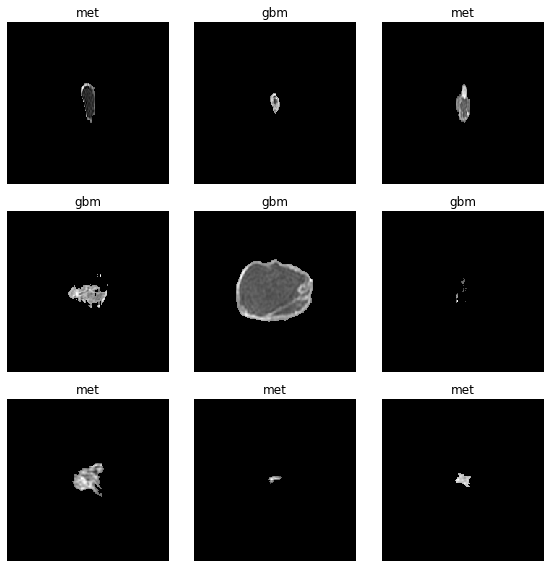

In [21]:
data.show_batch(rows=3, figsize=(8,8))

In [22]:
print(data.classes)
len(data.classes), data.c

['gbm', 'met']


(2, 2)

## Training: resnet50

In [23]:
# load pre-trained on ImageNet resnet50 model
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [24]:
# description of the model
learn.model;

[Explanation](https://sgugger.github.io/the-1cycle-policy.html) of "learn one cycle policy". By default fastai-practitioners use `learn.fit_one_cycle(4)`.

In [25]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.371107,0.388861,0.177432,05:01
1,0.316909,0.314915,0.151616,04:50
2,0.280603,0.300173,0.137095,04:52
3,0.268044,0.310581,0.139300,04:56


In [26]:
learn.save('stage-1-off-tfms-resnet50-ep4')

In [27]:
learn.load('stage-1-off-tfms-resnet50-ep4');

In [28]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.284951,0.299718,0.141828,04:47
1,0.271485,0.285904,0.128274,04:44
2,0.246634,0.289086,0.130264,04:45
3,0.231094,0.294769,0.129888,04:44


In [29]:
learn.save('stage-1-off-tfms-resnet50-ep8')

In [30]:
learn.load('stage-1-off-tfms-resnet50-ep8');

In [31]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.255529,0.328384,0.150110,04:43
1,0.256214,0.349199,0.154413,04:43
2,0.237222,0.293670,0.133921,04:43
3,0.220970,0.277406,0.122197,04:44


In [32]:
learn.save('stage-1-off-tfms-resnet50-ep12')

In [33]:
learn.load('stage-1-off-tfms-resnet50-ep12');

## Results

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

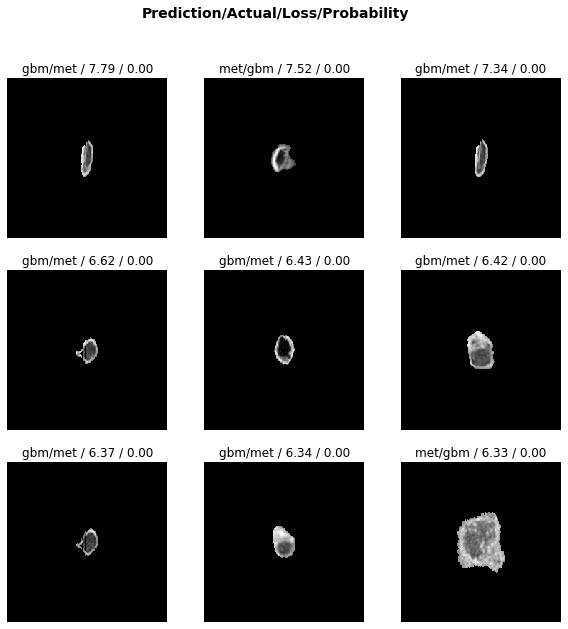

In [35]:
interp.plot_top_losses(9, figsize=(10, 10))

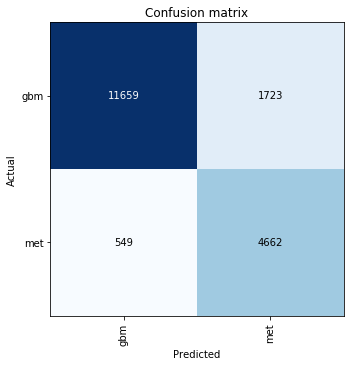

In [36]:
# manually fixing matplotlib's bug for correct confusion matrix display
cm_fig = interp.plot_confusion_matrix(return_fig=True, figsize=(5, 5))
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

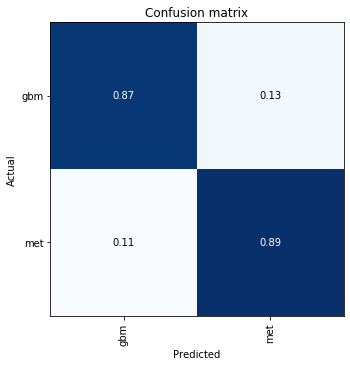

In [37]:
# manually fixing matplotlib's bug for correct confusion matrix display
cm_fig = interp.plot_confusion_matrix(return_fig=True, figsize=(5, 5), normalize=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

In [38]:
interp.most_confused(min_val=2)

[('gbm', 'met', 1723), ('met', 'gbm', 549)]

## Unfreeze, fine-tuning, and learning rates

In [39]:
learn.load('stage-1-off-tfms-resnet50-ep8');

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


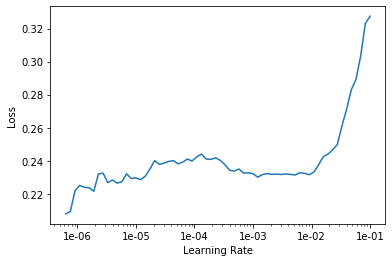

In [41]:
learn.recorder.plot()

In [42]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.315804,0.439933,0.219384,06:19
1,0.257572,3.418148,0.280267,06:18
2,0.211587,0.291538,0.127575,06:18
3,0.195843,0.260076,0.109288,06:19


In [43]:
learn.save('stage-2-off-tfms-resnet50-ep4')

In [44]:
learn.load('stage-2-off-tfms-resnet50-ep4');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


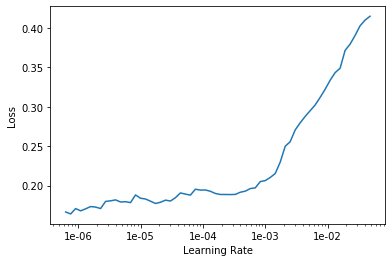

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.241107,0.281586,0.133491,06:18
1,0.234667,0.269726,0.117195,06:18
2,0.197330,0.269670,0.120637,06:18
3,0.162280,0.266096,0.106438,06:19


In [47]:
learn.save('stage-2-off-tfms-resnet50-ep8')

In [48]:
learn.load('stage-2-off-tfms-resnet50-ep8');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


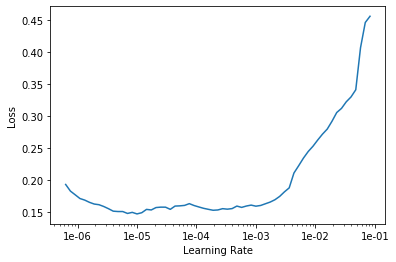

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6, 4e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.154127,0.268934,0.107298,06:18
1,0.149199,0.268189,0.106922,06:18
2,0.152127,0.269792,0.106545,06:18
3,0.151754,0.266735,0.106277,06:19


In [51]:
interp_stage_2 = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp_stage_2.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

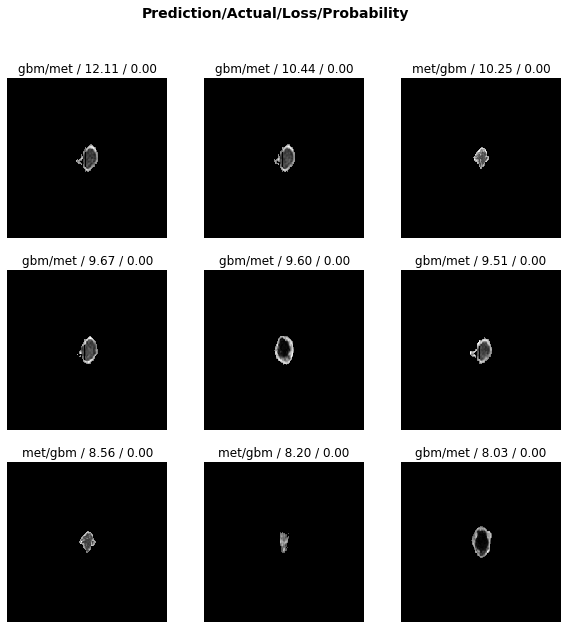

In [52]:
interp_stage_2.plot_top_losses(9, figsize=(10, 10))

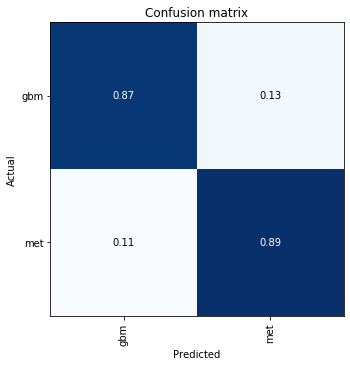

In [53]:
# manually fixing matplotlib's bug for correct confusion matrix display
cm_fig = interp.plot_confusion_matrix(return_fig=True, figsize=(5, 5), normalize=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

In [54]:
interp.most_confused(min_val=2)

[('gbm', 'met', 1723), ('met', 'gbm', 549)]

In [55]:
doc(ClassificationInterpretation)

class ClassificationInterpretation [source] [test] ClassificationInterpretation ( learn : Learner , preds : Tensor , y_true : Tensor , losses : Tensor , ds_type : DatasetType = <DatasetType.Valid: 2> ) :: Interpretation 
 
 × Tests found for ClassificationInterpretation : pytest -sv tests/test_vision_train.py::test_ClassificationInterpretation [source] To run tests please refer to this guide . Interpretation methods for classification models. 
 Show in docs

## Export model for further inference

In [56]:
# learn.load("stage-1-resnet50")

Save all the information of our `Learner` object for inference(`DataBunch`(transforms, classes, normalization...), the model with its weights and all the callbacks our `Learner` was using). Everything will be in a file named `export.pkl` in the folder `learn.path`.

In [57]:
learn.export()

In [58]:
learn.path

PosixPath('/storage_1/dataset_classification_threshold_45')